# Support.py in Notebook

In [1]:
import numpy as np
import os

import contextlib
import pandas as pd
from datetime import date, datetime

from pm4py.objects.petri_net.obj import PetriNet
from pm4py.visualization.petri_net import visualizer as pn_visualizer
from pm4py.objects.petri_net.utils.petri_utils import add_arc_from_to
from pm4py.objects.petri_net.obj import Marking
from pm4py import conformance
from pm4py.utils import constants

constants.SHOW_PROGRESS_BAR = False

activities = [
    "Invisible 1",
    "Invisible 2",
    "Receiving Request",
    "First Assessment",
    "Fraud Check",
    "Accept",
    "Decline",
    "Create Offer",
    "Contact Customer",
    "Offer Refused",
    "Draw Contract",
    "Send Contract",
]

NR_PLACES = 9

# loads and prepares the dataset for fitness evaluations
def load_dataset(path):
    res = []
    with open(path) as fi:
        for line in fi:
            res.append(line.strip().split(", "))

    # reformating the dataset to a pandas dataframe for pm4py compatibility
    df = pd.DataFrame(
        {
            "date": date.today(),
            "case:concept:name": [str(i) for i in range(len(res))],
            "concept:name": res,
        }
    )
    df["date"] = pd.to_datetime(df["date"])
    df = df.explode("concept:name")

    base_timestamp = datetime.now()
    df["time:timestamp"] = base_timestamp + pd.to_timedelta(df.index, unit="h")

    return df


DATASET = load_dataset("dataset_a1.txt")
NR_TRANSITIONS = len(activities)
NAMES_TO_TRANSITION = dict(zip(activities, range(NR_TRANSITIONS)))


def fitness(sol):
    matrix = list_to_array(sol)

    nr_violations = _get_nr_handcrafted_violations(matrix)
    alignment_score = _get_alignment_scores(matrix)
    return (alignment_score - nr_violations,)


def list_to_array(sol):
    return np.array(sol).reshape((NR_TRANSITIONS, 2))


def _get_nr_handcrafted_violations(matrix) -> int:
    nr_arrivals_to_first_place = (matrix[:, 1] == 0).sum()
    nr_departures_from_last_place = (matrix[:, 0] == NR_PLACES - 1).sum()
    nr_self_loops = (matrix[:, 0] == matrix[:, 1]).sum()
    nr_backwards_invisible = (matrix[:2, 0] > matrix[:2, 1] + 2).sum()
    nr_backwards_visible = (matrix[2:, 0] > matrix[2:, 1]).sum()

    return (
        nr_arrivals_to_first_place
        + nr_departures_from_last_place
        + nr_self_loops
        + nr_backwards_invisible
        + nr_backwards_visible
    )


def _get_alignment_scores(matrix) -> float:
    net, initial_marking, final_marking = matrix_to_petrinet(matrix)

    # Needed to redirect the output of the fitness_alignments function, which outputs a lot of text,
    with open(os.devnull, "w") as f:
        with contextlib.redirect_stdout(f), contextlib.redirect_stderr(f):
            try:
                fa = conformance.fitness_alignments(
                    log=DATASET,
                    petri_net=net,
                    initial_marking=initial_marking,
                    final_marking=final_marking,
                )
            except Exception as e:
                return -1

    alignment_score = fa["average_trace_fitness"]
    return alignment_score


# plot the Petri net
def sol_to_graphviz(sol, output_file="output.pdf"):
    matrix = list_to_array(sol)
    net, _, _ = matrix_to_petrinet(matrix)
    parameters = {pn_visualizer.Variants.WO_DECORATION.value.Parameters.FORMAT: "pdf"}
    gviz = pn_visualizer.apply(net, parameters=parameters)
    pn_visualizer.save(gviz, output_file)


def matrix_to_petrinet(matrix):
    net = PetriNet("PETRINAS")

    places_dict = {}

    for place_nr in range(NR_PLACES):
        place = PetriNet.Place(name=f"p{place_nr}")
        net.places.add(place)
        places_dict[place_nr] = place

        if place_nr == 0:
            first_marking = Marking()
            first_marking[place] = 1

        if place_nr >= NR_PLACES - 1:
            last_marking = Marking()
            last_marking[place] = 1

    for row, activity in enumerate(activities):
        if activity.startswith("Invisible"):
            transition = PetriNet.Transition(name=activity)
        else:
            transition = PetriNet.Transition(name=activity, label=activity)
        net.transitions.add(transition)

        start, end = matrix[row]

        start_place = places_dict[start]
        add_arc_from_to(start_place, transition, net)

        end_place = places_dict[end]
        add_arc_from_to(transition, end_place, net)

    return net, first_marking, last_marking


# Code 

In [2]:
import random
from deap import base, creator, tools, algorithms
import matplotlib.pyplot as plt

In [3]:
data = load_dataset("dataset_a1.txt")

## Q1

--- GA Parameters ---
Population Size (POP_SIZE): 100
Crossover Probability (CXPB): 0.7
Mutation Probability (MUTPB): 0.2
Number of Generations (NGEN): 20
Tournament Size (TOURNSIZE): 3
Attribute Mutation Probability (INDPB): 0.1
---------------------

gen	nevals	max     	avg     	min	std    
0  	100   	-3.65324	-9.09539	-17	3.16819
1  	69    	-1.86583	-6.4035 	-12	2.24645
2  	82    	-0.649952	-4.73853	-9 	1.69537
3  	82    	0.207779 	-3.42237	-7 	1.57097
4  	81    	0.470136 	-2.27651	-7 	1.46191
5  	72    	0.470136 	-1.42297	-5.49723	1.19711
6  	74    	0.538094 	-0.778348	-4.95574	1.14824
7  	75    	0.540094 	-0.246959	-5      	1.00206
8  	77    	0.578636 	0.0380846	-3.95574	0.822374
9  	69    	0.579431 	0.228786 	-2.65324	0.637558
10 	72    	0.619179 	0.240986 	-3.46191	0.735637
11 	77    	0.644689 	0.29191  	-3      	0.607164
12 	75    	0.65184  	0.12147  	-2.70324	0.914152
13 	77    	0.65184  	0.320279 	-2.7071 	0.66537 
14 	69    	0.685231 	0.425976 	-1.46191	0.451217
15 	64    	0

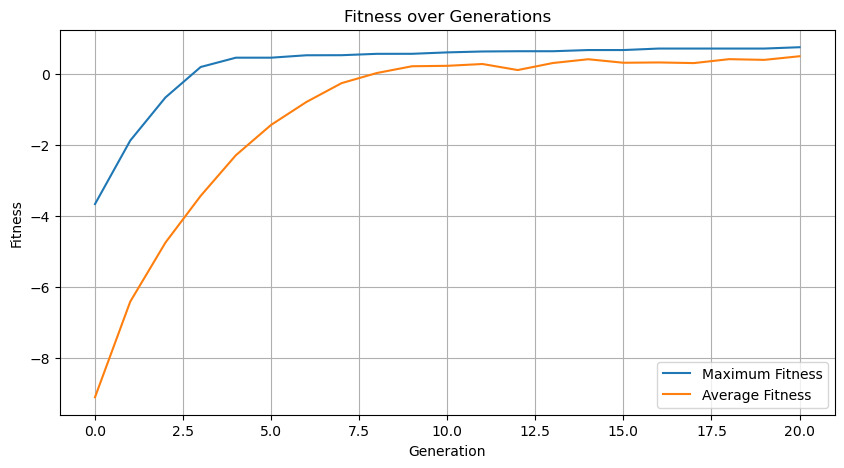

In [4]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

toolbox.register("attr_int", random.randint, 0, NR_PLACES - 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_int, n=NR_TRANSITIONS * 2)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", fitness) 
toolbox.register("mate", tools.cxTwoPoint) 
toolbox.register("mutate", tools.mutUniformInt, low=0, up=NR_PLACES - 1, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=3)

POP_SIZE = 100
CXPB = 0.7       # Crossover Probability
MUTPB = 0.2      # Mutation Probability
NGEN = 20        # Number of Generations
TOURNSIZE = 3    # Tournament Size (already set in selTournament registration)
INDPB = 0.1      # Independent probability for attributes mutation (already set in mutUniformInt registration)

print("--- GA Parameters ---")
print(f"Population Size (POP_SIZE): {POP_SIZE}")
print(f"Crossover Probability (CXPB): {CXPB}")
print(f"Mutation Probability (MUTPB): {MUTPB}")
print(f"Number of Generations (NGEN): {NGEN}")
print(f"Tournament Size (TOURNSIZE): {TOURNSIZE}")
print(f"Attribute Mutation Probability (INDPB): {INDPB}")
print("---------------------\n")

stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("max", np.max)
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("std", np.std)

pop = toolbox.population(n=POP_SIZE)
hof = tools.HallOfFame(1) # Store the best individual

pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=CXPB, mutpb=MUTPB, ngen=NGEN,
                                   stats=stats, halloffame=hof, verbose=True)

best_ind = hof[0]
print("\n--- Best Individual Found ---")
print(best_ind)
print(f"Fitness: {best_ind.fitness.values[0]}")

best_matrix = list_to_array(best_ind)
print("\nBest Matrix:")
print(best_matrix)

gen = logbook.select("gen")
max_fitness = logbook.select("max")
avg_fitness = logbook.select("avg")

plt.figure(figsize=(10, 5))
plt.plot(gen, max_fitness, label="Maximum Fitness")
plt.plot(gen, avg_fitness, label="Average Fitness")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Fitness over Generations")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Visualize the best Petri net found
output_filename = "best_petri_net.pdf"
sol_to_graphviz(best_ind, output_file=output_filename)
print(f"\nBest Petri net saved to {output_filename}")

# Q2

In [ ]:
POP_SIZE = 100
CXPB = 0.7
MUTPB = 0.2
NGEN = 10
TOURNSIZE = 3
INDPB = 0.1
NUM_RUNS = 10

final_best_fitness_values = []
generational_max_fitness = [] 

print(f"--- Running GA {NUM_RUNS} times ---")

for run in range(NUM_RUNS):
    print(f"\n--- Run {run + 1}/{NUM_RUNS} ---")
    pop = toolbox.population(n=POP_SIZE)
    hof = tools.HallOfFame(1)

    stats_run = tools.Statistics(lambda ind: ind.fitness.values)
    stats_run.register("max", np.max)

    pop, logbook_run = algorithms.eaSimple(pop, toolbox, cxpb=CXPB, mutpb=MUTPB, ngen=NGEN,
                                            stats=stats_run, halloffame=hof, verbose=False)

    best_fitness_run = hof[0].fitness.values[0]
    final_best_fitness_values.append(best_fitness_run)
    generational_max_fitness.append(logbook_run.select("max"))

    print(f"Run {run + 1} Best Fitness: {best_fitness_run}")

print(f"\n--- Finished {NUM_RUNS} runs ---")

plt.figure(figsize=(8, 6))
plt.boxplot(final_best_fitness_values, patch_artist=True)
plt.title(f'Distribution of Best Fitness Values across {NUM_RUNS} Runs')
plt.ylabel('Best Fitness')
plt.xticks([1], ['GA Runs'])
plt.grid(axis='y')
plt.show()

max_len = NGEN + 1 
padded_fitness = []
for run_data in generational_max_fitness:
    if len(run_data) < max_len:
        padded_run = run_data + [run_data[-1]] * (max_len - len(run_data))
        padded_fitness.append(padded_run)
    else:
        padded_fitness.append(run_data[:max_len])

abf_per_generation = np.mean(padded_fitness, axis=0)
generations = np.arange(len(abf_per_generation))

plt.figure(figsize=(10, 5))
plt.plot(generations, abf_per_generation, marker='o', linestyle='-')
plt.title(f'Average Best Fitness (ABF) over Generations ({NUM_RUNS} Runs)')
plt.xlabel('Generation')
plt.ylabel('Average Best Fitness')
plt.grid(True)
plt.xticks(np.arange(0, NGEN + 1, step=max(1, NGEN // 10)))
plt.show()

print("\n--- Analysis Complete ---")
print(f"Final Best Fitness Values: {final_best_fitness_values}")
print(f"Average Best Fitness per Generation: {abf_per_generation}")

# Q3